In [1]:
import glob
import pandas as pd
import os as os
import matplotlib.pyplot as plt


path =r'Data/russian_tweets/'
allFiles = glob.glob(os.path.join(path, "*.csv"))
troll = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
troll = pd.concat(list_)

In [2]:
print troll.shape

(2973371, 15)


In [3]:
troll.isnull().sum().sort_values(ascending = False)

post_type             1662425
region                   8843
account_type              363
external_author_id          4
content                     1
account_category            0
retweet                     0
new_june_2018               0
updates                     0
followers                   0
following                   0
harvested_date              0
publish_date                0
language                    0
author                      0
dtype: int64

In [4]:
print(troll.dtypes)

external_author_id    float64
author                 object
content                object
region                 object
language               object
publish_date           object
harvested_date         object
following               int64
followers               int64
updates                 int64
post_type              object
account_type           object
new_june_2018           int64
retweet                 int64
account_category       object
dtype: object


In [5]:
troll['publish_date'] = pd.to_datetime(troll['publish_date'])

In [6]:
start_date_tweet = troll['publish_date'].min()
end_date_tweet = troll['publish_date'].max()
print start_date_tweet,end_date_tweet

2012-02-02 00:35:00 2018-05-30 21:01:00


In [7]:
troll['created_str_date'] = pd.to_datetime(troll['publish_date'].dt.date)

In [8]:
# Count the number of times a date appears in the dataset and convert to dataframe
tweet_trend = pd.DataFrame(troll['created_str_date'].value_counts())

# index is date, columns indicate tweet count on that day
tweet_trend.columns = ['tweet_count']
# sort the dataframe by the dates to have them in order
tweet_trend.sort_index(ascending = True, inplace = True)

In [9]:
print tweet_trend['tweet_count'].sort_values(ascending=False).head(15)

2016-10-06    18722
2017-08-16    14720
2017-08-15    13375
2017-08-17    13066
2017-08-12    12981
2017-08-18    12470
2017-08-13    10981
2017-08-14    10700
2016-10-07    10356
2015-07-22     9564
2016-09-19     9298
2017-08-10     8738
2017-08-07     8717
2015-11-27     8709
2017-08-09     8689
Name: tweet_count, dtype: int64


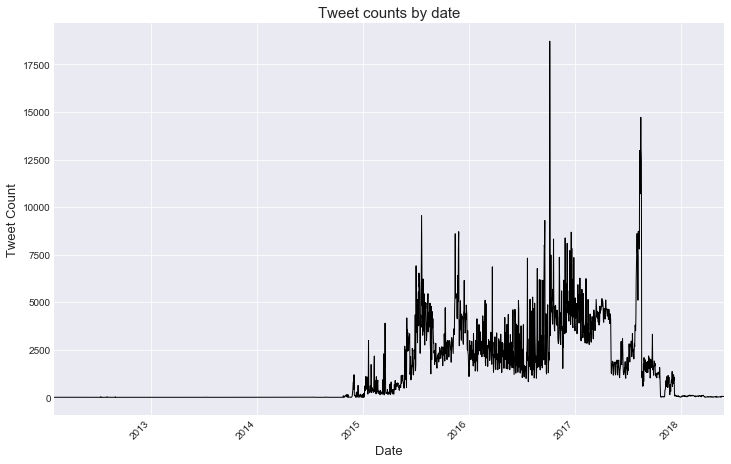

In [10]:
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

In [11]:
dates_list = ['2015-11-27', '2015-07-22', '2016-02-01',
              '2017-08-16', '2017-08-17', '2016-03-11',
              '2016-05-03', '2016-05-26', '2016-06-20', 
              '2016-07-15', '2016-07-21', '2016-08-17',
              '2016-09-26', '2016-10-07', '2016-10-06']

# create a series of these dates.
important_dates = pd.Series(pd.to_datetime(dates_list))

# add columns to identify important events, and mark a 0 or 1.
tweet_trend['Important Events'] = False
tweet_trend.loc[important_dates, 'Important Events'] = True
tweet_trend['values'] = 0
tweet_trend.loc[important_dates, 'values'] = 1

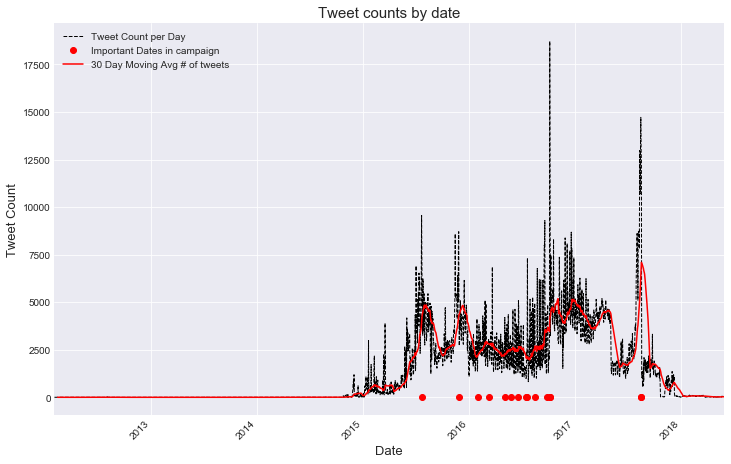

In [12]:
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "--", 
                                figsize = (12,8), rot = 45, 
                                color = 'k',
                                label = 'Tweet Count per Day',
                               linewidth = 1)

# plot dots for where values in the tweet_trend df are 1
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in campaign')

# Lets add a 30 day moving average on top to view the trend! Min_periods tells rolling() to
# use 10 points if 30 not available!
plt.plot(tweet_trend['tweet_count'].rolling(window = 30, min_periods = 10).mean(), 
         color = 'r', 
         label = '30 Day Moving Avg # of tweets')
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)
plt.legend(loc = 'best')

In [13]:
troll['content'].head(10)

0    People are too toxic. I think I have people po...
1    #NowPlaying Don't Shoot (I'm a Man) by @DEVO -...
2    the 'I'm the most boring person in the world' ...
3    #MyAchillesHeel slippery floors https://t.co/R...
4    #MyAchillesHeel Boring narcissists.....nothing...
5    Your opinion on Hillary really matters to a no...
6            #MyAchillesHeel Lilith from Frasier.  0_O
7    Come find us at the national mall for the #DC ...
8    #MyAchillesHeel  Trolling celebrities.  I have...
9                     #MyAchillesHeel  Morbid comedy �
Name: content, dtype: object

In [14]:
troll.dropna(subset = ['content'], inplace = True)
trolls = troll.query('account_category == "RightTroll" |account_category == "LeftTroll" | account_category == "NewsFeed"')
print trolls.shape
import re
def remove_retweet(tweet):
    '''Given a tweet, remove the retweet element from it'''
    text_only = []
    if len(re.findall("^RT.*?:(.*)", tweet)) > 0:
        text_only.append(re.findall("^RT.*?:(.*)", tweet)[0])
    else:
        text_only.append(tweet)
    return text_only[0]

# extract texts and place in a list
text_only = trolls.query('language=="English"')['content'].map(remove_retweet)

(1746192, 16)


In [15]:
print text_only.shape

(1732807,)


In [16]:
def remove_links(tweet):
    '''Provide a tweet and remove the links from it'''
    text_only = []
    if len(re.findall("(https://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(https://[^\s]+)", "", tweet)
    if len(re.findall("(http://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(http://[^\s]+)", "", tweet)    
    text_only.append(tweet)
    return text_only[0]

text_no_links = text_only.map(remove_links)

In [17]:
def remove_hashtags(tweet):
    '''Provide a tweet and remove hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        tweet = re.sub("(#[^#\s]+)", "", tweet) 
    hashtags_only.append(tweet)
    return hashtags_only[0]

text_all_removed = text_no_links.map(remove_hashtags)

In [18]:
def remove_extraneous(tweet):
    '''Given a text, remove unnecessary characters from the beginning and the end'''
    tweet = tweet.rstrip()
    tweet = tweet.lstrip()
    tweet = tweet.rstrip(")")
    tweet = tweet.lstrip("(")
    tweet = re.sub("\.", "", tweet)
    return tweet

text_clean = text_all_removed.map(remove_extraneous)

In [21]:
def extract_hashtags(tweet):
    '''Provide a tweet and extract hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        hashtags_only.append(re.findall("(#[^#\s]+)", tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

# make a new column to store the extracted hashtags and view them!
tweet_hashtags = troll.query('account_category == "RightTroll" |account_category == "LeftTroll" | account_category == "NewsFeed"')['content'].map(extract_hashtags)
#troll['tweet_hashtags'].head(10)

In [22]:
print tweet_hashtags

2028                                                   [0]
2029                                                   [0]
2030                                                   [0]
2031                                                   [0]
2032                                                   [0]
2033                                                   [0]
2034                                                   [0]
2035                       [#MarcusTulliusCicero:, #quote]
2036                                                   [0]
2037                                                   [0]
2038                                                   [0]
2039                                                   [0]
2040                                                   [0]
2041                                                   [0]
2042                                                   [0]
2043                                                   [0]
2044                                                   [

In [23]:
# create a list of all hashtags
all_hashtags = tweet_hashtags

# Next we observe that our all_hashtags is a list of lists...lets change that
cleaned_hashtags = []
for i in all_hashtags:
    for j in i:
            cleaned_hashtags.append(j)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()

In [24]:
hashes = cleaned_hashtag_series.values
hashes = hashes.tolist()
hashes= filter(lambda a: a != '0', hashes)


In [25]:
from collections import Counter
print Counter(hashes)

Counter({'#news': 127016, '#sports': 48587, '#politics': 39717, '#world': 27540, '#local': 25806, '#TopNews': 15159, '#MAGA': 12366, '#health': 11448, '#tcot': 11210, '#BlackLivesMatter': 11190, '#business': 10816, '#PJNET': 10331, '#tech': 8217, '#entertainment': 7577, '#top': 7486, '#Cleveland': 6689, '#TopVideo': 6553, '#crime': 6497, '#environment': 5785, '#ISIS': 4939, '#mar': 4920, '#Miami': 4535, '#breaking': 4497, '#topl': 4416, '#Trump': 4179, '#SanJose': 4154, '#IslamKills': 4126, '#2A': 3980, '#WakeUpAmerica': 3947, '#life': 3920, '#FAKENEWS!': 3753, '#GOPDebate': 3678, '#NowPlaying': 3457, '#TCOT': 3434, '#ccot': 3293, '#Chicago': 3212, '#amb': 2949, '#TrumpTrain': 2678, '#may': 2601, '#Texas': 2558, '#p2': 2543, '#US': 2506, '#DemnDebate': 2501, '#SanDiego': 2428, '#Foke': 2416, '#pjnet': 2321, '#VegasGOPDebate': 2293, '#Trump2016': 2257, '#DemDebate': 2249, '#CCOT': 2242, '#Syria': 2218, '#Wisconsin': 2168, '#News': 2156, '#th': 2126, '#Brussels': 2091, '#BlackTwitter': 1

In [26]:
i=0
value1=[]
value2=[]
for x in Counter(hashes).most_common(100):
    value1.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x[0]).split()))
    value2.append(x[1])
print value1
print value2
df = pd.DataFrame({'hashtag':value1,'count':value2})

['news', 'sports', 'politics', 'world', 'local', 'TopNews', 'MAGA', 'health', 'tcot', 'BlackLivesMatter', 'business', 'PJNET', 'tech', 'entertainment', 'top', 'Cleveland', 'TopVideo', 'crime', 'environment', 'ISIS', 'mar', 'Miami', 'breaking', 'topl', 'Trump', 'SanJose', 'IslamKills', '2A', 'WakeUpAmerica', 'life', 'FAKENEWS', 'GOPDebate', 'NowPlaying', 'TCOT', 'ccot', 'Chicago', 'amb', 'TrumpTrain', 'may', 'Texas', 'p2', 'US', 'DemnDebate', 'SanDiego', 'Foke', 'pjnet', 'VegasGOPDebate', 'Trump2016', 'DemDebate', 'CCOT', 'Syria', 'Wisconsin', 'News', 'th', 'Brussels', 'BlackTwitter', 'Obama', 'NeverHillary', 'NowPlaying', 'USFA', 'StLouis', 'BLM', 'OscarHasNoColor', 'StopTheGOP', 'money', 'TrumpForPresident', 'PoliceBrutality', 'jud', 'StopIslam', 'Prayers4California', 'blacklivesmatter', 'MakeAmericaGreatAgain', 'Breaking', 'art', 'imo', 'StayWoke', 'RT', 'CruzCrew', 'MAGA', 'TrumpBecause', 'BlackSkinIsNotACrime', 'NoDAPL', 'Hillary', 'marv', 'vvmar', 'hiphop', 'soundcloud', 'SAA', 'G

Axes(0.125,0.125;0.775x0.755)


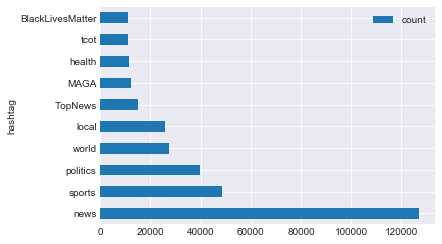

In [27]:
print df.head(10).plot(x='hashtag',y='count',kind='barh')

In [32]:
print df['hashtag'].head(50)

0                 news
1               sports
2             politics
3                world
4                local
5              TopNews
6                 MAGA
7               health
8                 tcot
9     BlackLivesMatter
10            business
11               PJNET
12                tech
13       entertainment
14                 top
15           Cleveland
16            TopVideo
17               crime
18         environment
19                ISIS
20                 mar
21               Miami
22            breaking
23                topl
24               Trump
25             SanJose
26          IslamKills
27                  2A
28       WakeUpAmerica
29                life
30            FAKENEWS
31           GOPDebate
32          NowPlaying
33                TCOT
34                ccot
35             Chicago
36                 amb
37          TrumpTrain
38                 may
39               Texas
40                  p2
41                  US
42          DemnDebate
43         

In [ ]:
d = {}
for a, x in df.values:
    d[x]=a
print d

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width= 1600, height = 800, 
                      relative_scaling = 0.6, 
                      colormap = "Blues",
                     max_words = 100).generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()